In [1]:
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append("..")
import numpy as np

def get_all_params_flattend(model):
    params = np.array([], dtype=np.float32)
    with torch.no_grad():
        params = np.concatenate((params, model.conv1.weight.data.reshape(-1)))
        params = np.concatenate((params, model.conv1.bias.data.reshape(-1)))
        params = np.concatenate((params, model.conv2.weight.data.reshape(-1)))
        params = np.concatenate((params, model.conv2.bias.data.reshape(-1)))
        params = np.concatenate((params, model.fc1.weight.data.reshape(-1)))
        params = np.concatenate((params, model.fc1.bias.data.reshape(-1)))
        params = np.concatenate((params, model.fc2.weight.data.reshape(-1)))
        params = np.concatenate((params, model.fc1.bias.data.reshape(-1)))
    return params

from sklearn.preprocessing import StandardScaler
def standardization(all_params):
    all_params = StandardScaler().fit_transform(all_params)
#     for ii in range(len(all_params)):
#         print("User[{}]:\tMax {:.4f}\tMin {:.4f}\tMean {:.4f}\tSTD {:.4f}".format(
#             ii, np.max(all_params[ii]), np.min(all_params[ii]), np.mean(all_params[ii]), np.std(all_params[ii])))
    return all_params

from sklearn.decomposition import PCA
def draw_pca_model(params_list, colors, title):
    pca = PCA(n_components=2)
    proj = pca.fit_transform(params_list)
    figure = plt.figure(figsize=(18, 8))
    plt.title(title)
    plt.scatter(proj[:, 0], proj[:,1], c = colors, cmap="brg")
    plt.annotate("w0", (proj[len(proj) - 2, 0], proj[len(proj) - 2, 1]), textcoords="offset points", xytext=(5,5))
    plt.annotate("server", (proj[len(proj) - 1, 0], proj[len(proj) - 1, 1]), textcoords="offset points", xytext=(5,5))
    plt.colorbar(ticks=range(30))

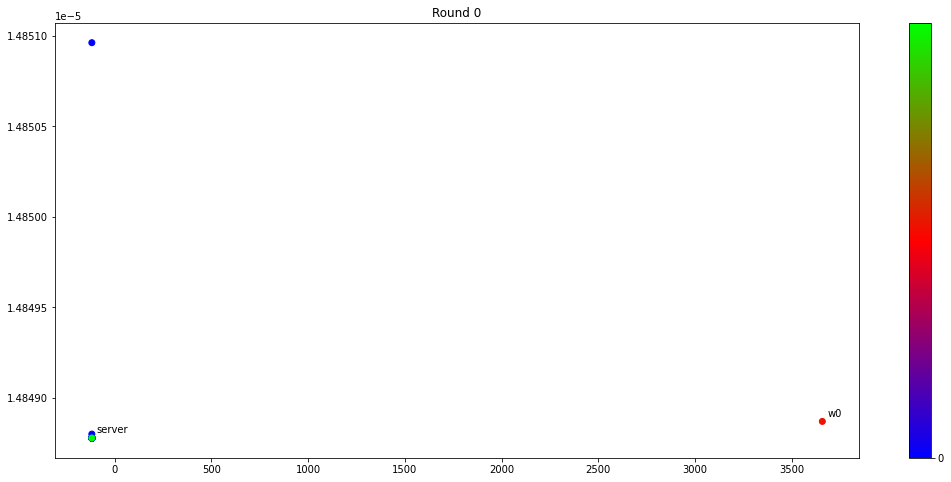

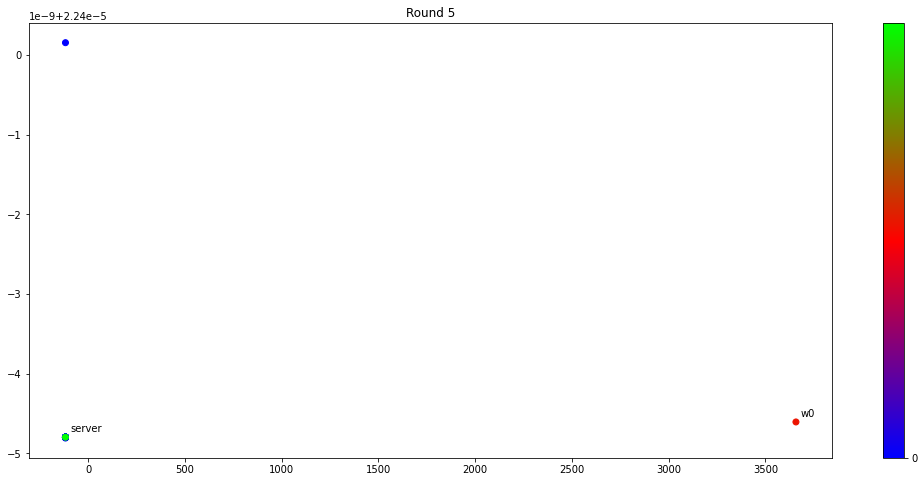

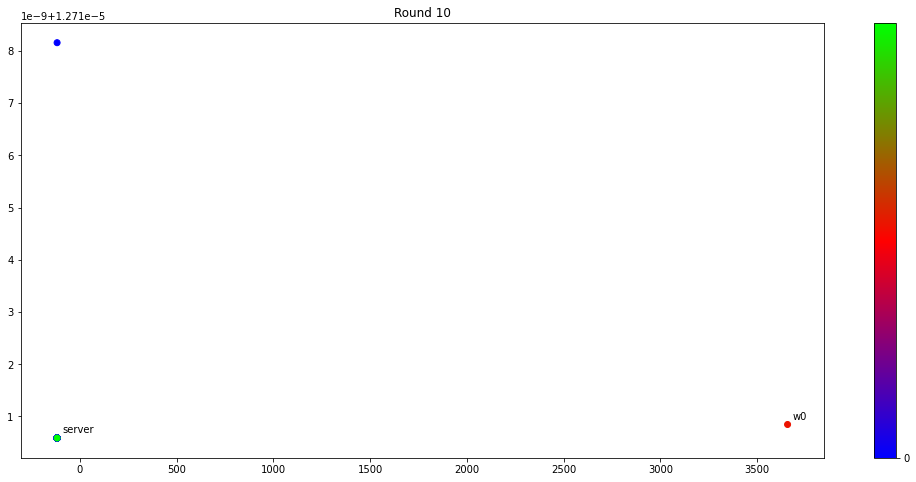

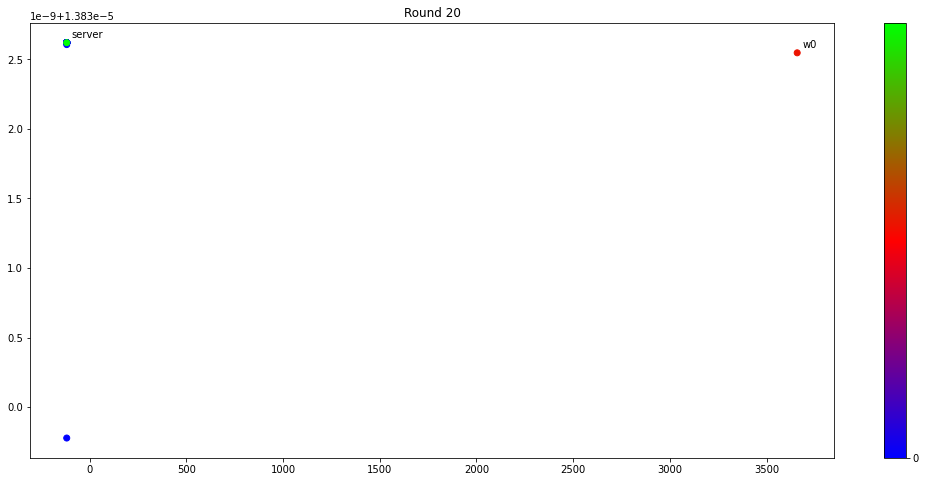

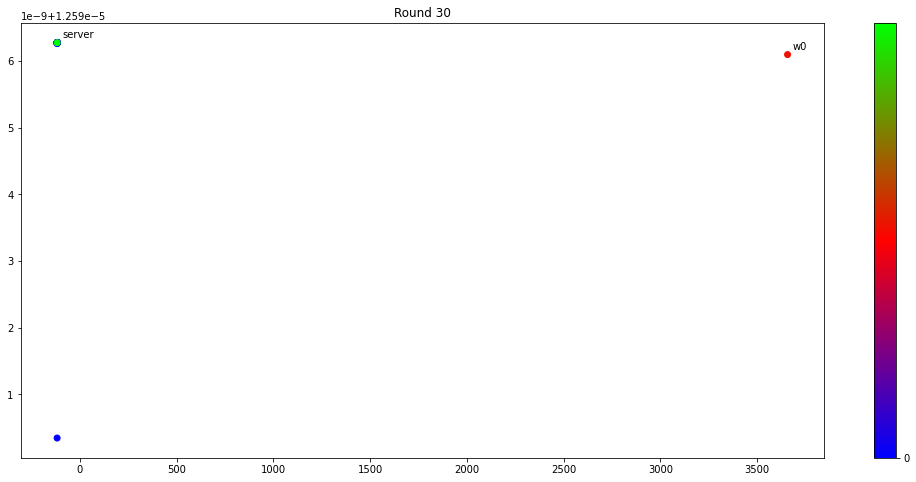

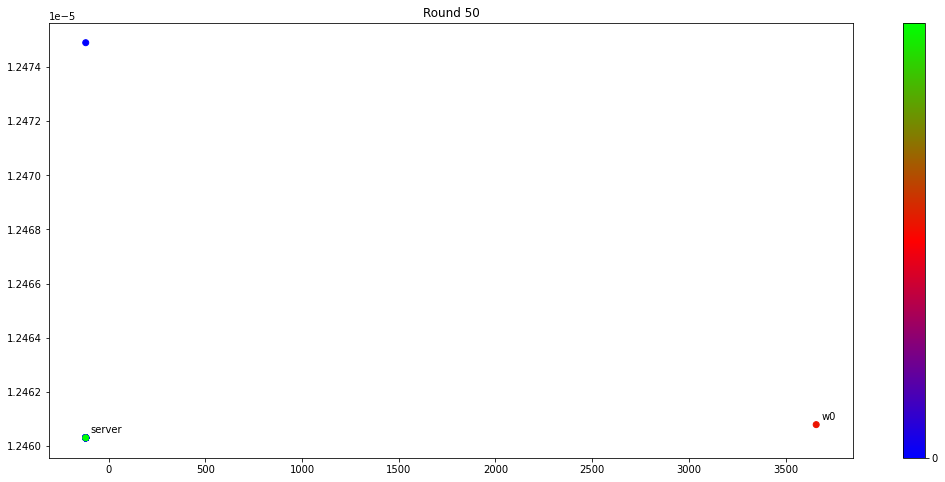

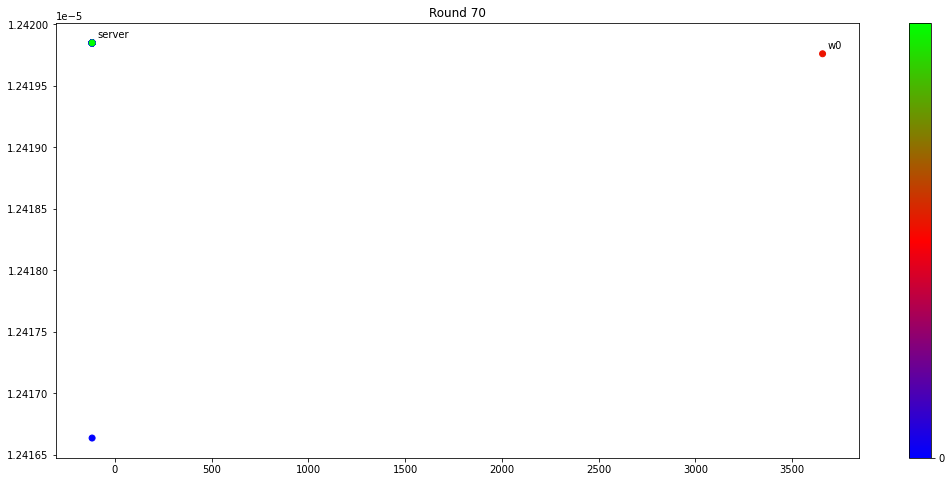

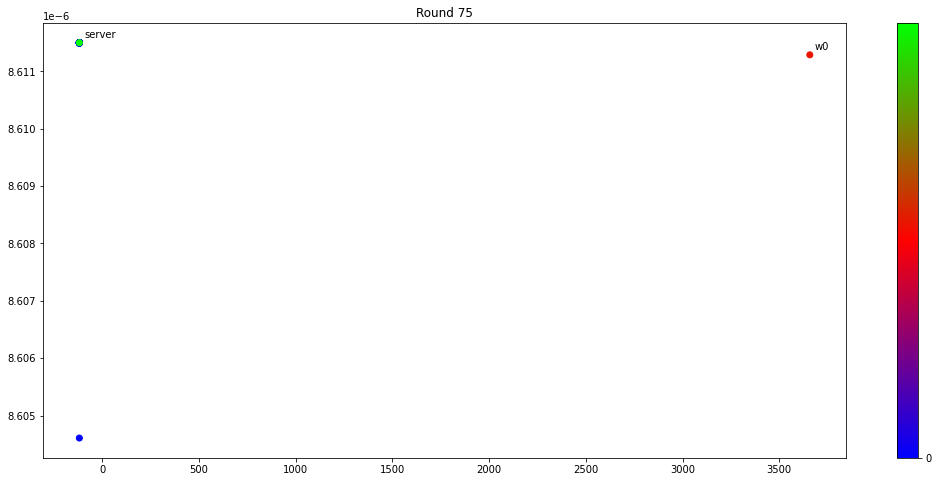

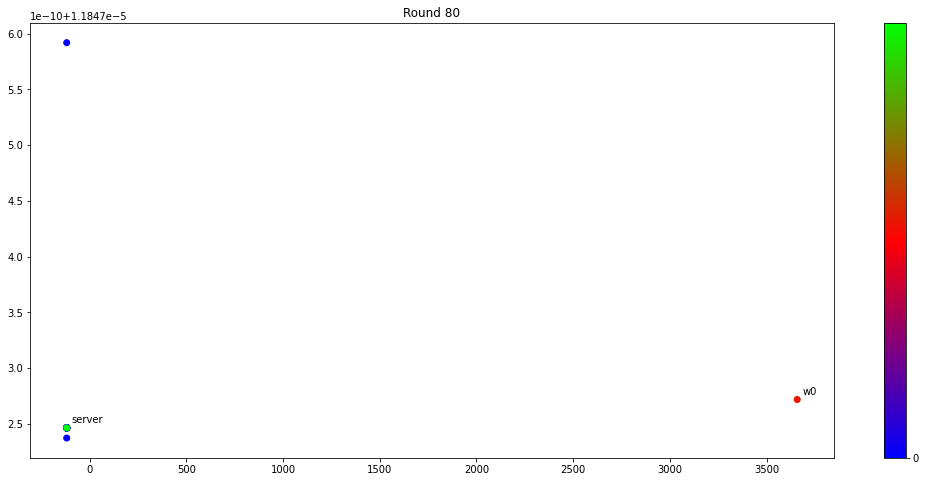

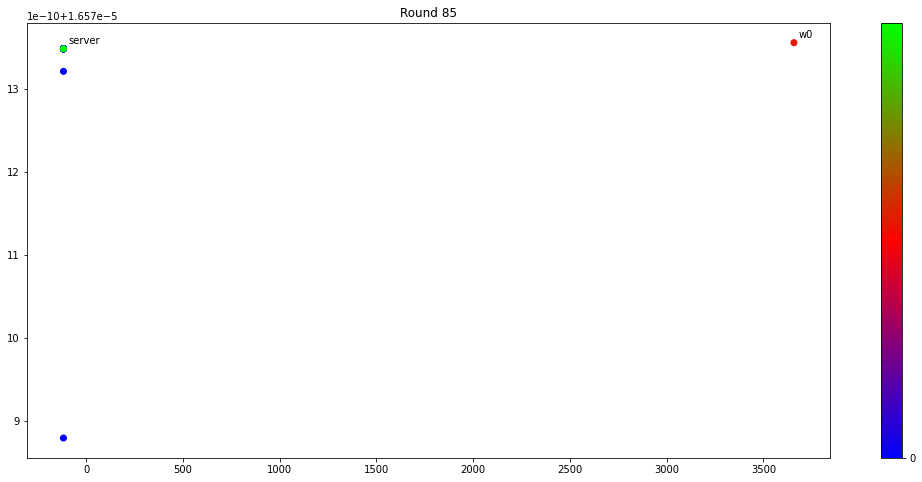

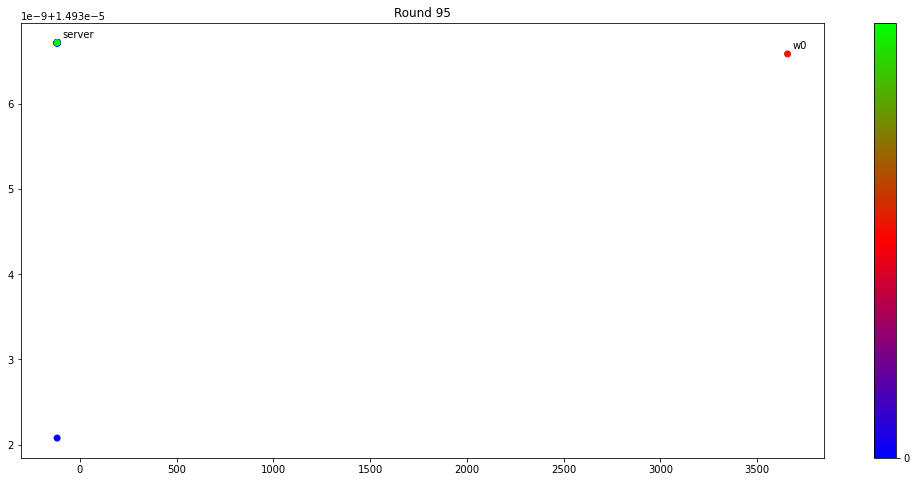

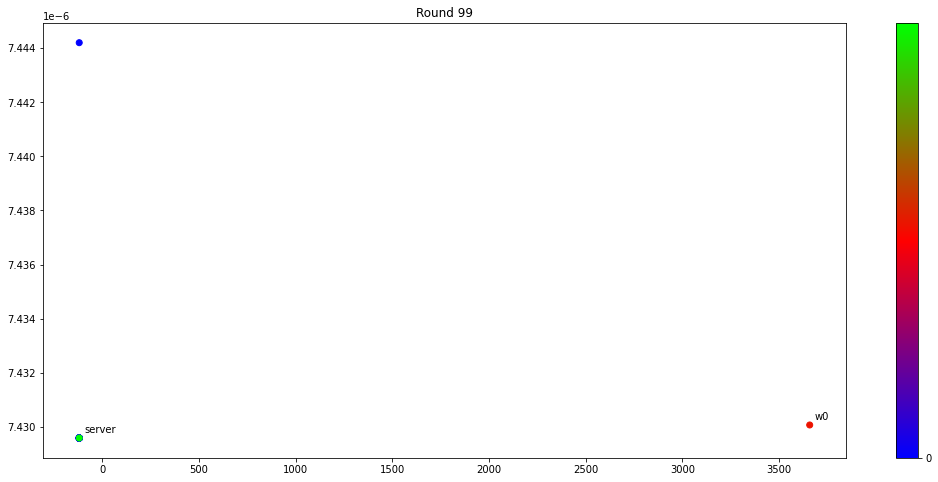

In [2]:
rounds = [0, 5, 10, 20, 30, 50, 70, 75, 80, 85, 95, 99]
num_workers = 30
file_path = "../data_output/20201109_023124_mnist_no_attack_worker_update_batch20_opt/"
w0_path = "../data_output/20201108_225254_mnist_w0/models/server_model_49"

with open("{}/eavesdroppers".format(file_path)) as f:
    eavesdoppers = [int(i) for i in f.readlines()[0].replace('[','').replace(']','').split(', ')]
color_map = [1 if ii in eavesdoppers else 0 for ii in range(num_workers)]
color_map.append(0.35) #For the w0
color_map.append(0.65) #For the server

server_model=torch.load(w0_path)
w0_params = get_all_params_flattend(server_model).reshape(1, -1)

for rr in rounds:
    all_params = np.array([], dtype=np.float32).reshape(-1, 431570) 
    # 431570 is the nmber of all params in a model
    for ww in range(num_workers):
        model_path = "{}/models/R{}_worker_{}".format(file_path, rr, ww)
        worker_model = torch.load(model_path)
        params = get_all_params_flattend(worker_model).reshape(1, -1)
        all_params = np.concatenate((all_params, params))
    
    server_path = "{}/models/server_model_{}".format(file_path, rr)
    server_model = torch.load(server_path)
    server_params= get_all_params_flattend(server_model).reshape(1, -1)
    all_params = np.concatenate((all_params, w0_params))
    all_params = np.concatenate((all_params, server_params))
    all_params = standardization(all_params)
    draw_pca_model(all_params, color_map, "Round {}".format(rr))
